## Multisensory modulation
This code examines how single neurons were modulated by multisensory information compared to unimodal information.

In [1]:
import os
from pathlib import Path
import numpy as np
import pandas as pd

from scipy import stats
import statsmodels.api as sm

import pingouin as pg

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import date
import time

import h5py

In [2]:
# no top and right spines in all plots
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

In [3]:
mother_path = Path('D:/Multi-modal project/')
#mother_path = Path('/Users/limhy/Desktop/Multi-modal project')
fig_path = mother_path / 'analysis' / 'result' / 'figures'

### Parameter setting

In [4]:
# colors for multimodal, vis-only, aud-only conditions
color = ['tab:blue','tab:red','tab:gray']
color2 = ['cyan','magenta','gray']
linestyle = ['-',':']

today = str(date.today())

### Data preparation

In [5]:
# load hdf5 files containing shuffled results
data_path = mother_path /'analysis'/'result'/'3. ANOVA'/'2023-07-10'
data2_path = mother_path /'analysis'/'result'/'3.1 Multiple linear regression'/'2023-07-10'
f = h5py.File(data_path/'2023-07-10_ANOVA_result.hdf5','r')
f2 = h5py.File(data2_path/'2023-07-10_multiple_regression_result.hdf5','r')

# load performance (correctness) data
corr_data = pd.read_csv(mother_path / 'analysis' / 'result' / 'correctness.csv')

In [6]:
def h5_to_df(f):
    keys = list(f.keys())
    attributes = {}
    
    for key in keys:
        attributes[key] = dict(f[key].attrs.items())
    
    df = pd.DataFrame.from_dict(attributes, orient='index')
    df.index.name = 'key'
    df = df.reset_index()
    
    return df

In [7]:
df = h5_to_df(f2)
df = df[(df['region']=='PER')&(df['response cell']==0)]
df.reset_index(inplace=True,drop=True)

for key in df['key']:  
    
    df.loc[df['key']==key,'pref_obj'] = f[key].attrs['preferred object']
    df.loc[df['key']==key,'peak_selectivity'] = np.max(f[f'{key}/anova_eta'])  
    df.loc[df['key']==key,'peak_selectivity_time'] = f[key].attrs['peak selectivity time']
    df.loc[df['key']==key,'selectivity_duration'] = len(f[f'{key}/object_bin'])*10
    df.loc[df['key']==key,'selectivity_onset'] = np.min(f[f'{key}/object_bin'])*10
    df.loc[df['key']==key,'selectivity_index'] = f[key].attrs['selectivity index']
    
    # load performance (correctness) data
    rat = 'LE'+str(df.loc[df['key']==key,'rat'].item())
    ss = int(df.loc[df['key']==key,'session'].item())
    df.loc[df['key']==key,'M_corr'] = corr_data.loc[(corr_data.rat==rat) & (corr_data.session==ss), 'M'].item()
    df.loc[df['key']==key,'V_corr'] = corr_data.loc[(corr_data.rat==rat) & (corr_data.session==ss), 'V'].item()
    df.loc[df['key']==key,'A_corr'] = corr_data.loc[(corr_data.rat==rat) & (corr_data.session==ss), 'A'].item()
    df.loc[df['key']==key,'C_corr'] = corr_data.loc[(corr_data.rat==rat) & (corr_data.session==ss), 'C'].item()
    
    # load beta coefficients and multisensory modulation index
    if f[key].attrs['preferred object'] == 'Boy':
        df.loc[df['key']==key,'coef_pref_image'] = f2[f'{key}/basic/beta_coef'][0]
        df.loc[df['key']==key,'coef_pref_sound'] = f2[f'{key}/basic/beta_coef'][1]
        
        df.loc[df['key']==key,'coef_nonpref_image'] = f2[f'{key}/basic/beta_coef'][2]
        df.loc[df['key']==key,'coef_nonpref_sound'] = f2[f'{key}/basic/beta_coef'][3]
        
        df.loc[df['key']==key,'pref_MV_mod'] = f[f'{key}/multi_cohend'][0]
        df.loc[df['key']==key,'pref_MA_mod'] = f[f'{key}/multi_cohend'][1]
        
        df.loc[df['key']==key,'nonpref_MV_mod'] = f[f'{key}/multi_cohend'][2]
        df.loc[df['key']==key,'nonpref_MA_mod'] = f[f'{key}/multi_cohend'][3]        
    else:
        df.loc[df['key']==key,'coef_pref_image'] = f2[f'{key}/basic/beta_coef'][2]
        df.loc[df['key']==key,'coef_pref_sound'] = f2[f'{key}/basic/beta_coef'][3]
        
        df.loc[df['key']==key,'coef_nonpref_image'] = f2[f'{key}/basic/beta_coef'][0]
        df.loc[df['key']==key,'coef_nonpref_sound'] = f2[f'{key}/basic/beta_coef'][1]
        
        df.loc[df['key']==key,'pref_MV_mod'] = f[f'{key}/multi_cohend'][2]
        df.loc[df['key']==key,'pref_MA_mod'] = f[f'{key}/multi_cohend'][3]
        
        df.loc[df['key']==key,'nonpref_MV_mod'] = f[f'{key}/multi_cohend'][0]
        df.loc[df['key']==key,'nonpref_MA_mod'] = f[f'{key}/multi_cohend'][1]      
        
df['peak_selectivity_time_range'] = (df['peak_selectivity_time'] // 100) + 1        

for i in range(len(df)):
    if df.loc[i,'peak_selectivity_time'] < 200:    # sample first half
        df.loc[i,'peak_selectivity_time_range2'] = 0    
    elif 200 <= df.loc[i,'peak_selectivity_time'] < 400:    # sample second half
        df.loc[i,'peak_selectivity_time_range2'] = 1
    elif 400 <= df.loc[i,'peak_selectivity_time'] < 650:    # response first half
        df.loc[i,'peak_selectivity_time_range2'] = 2
    elif 650 <= df.loc[i,'peak_selectivity_time'] < 900:    # response second half
        df.loc[i,'peak_selectivity_time_range2'] = 3

### Classifying visual, auditory, and unbiased neurons

In [8]:
# classification based on permutation test (shuffling)
for i in range(len(df)):
    k = df.loc[i,'key']
    beta_diff = df.loc[i,'coef_pref_image']-df.loc[i,'coef_pref_sound']
    if df.loc[i,'pref_obj']=='Boy':
        beta_diff_shuffle = np.subtract(f2[f'{key}/basic_shuffle/beta_coef'][:,0],
                                        f2[f'{key}/basic_shuffle/beta_coef'][:,1])
    else:
        beta_diff_shuffle = np.subtract(f2[f'{key}/basic_shuffle/beta_coef'][:,2],
                                        f2[f'{key}/basic_shuffle/beta_coef'][:,3])
    visual_crit = np.percentile(beta_diff_shuffle,97.5)
    auditory_crit = np.percentile(beta_diff_shuffle,2.5)
    
    if beta_diff > visual_crit:
        df.loc[i,'Category'] = 'visual'
    elif beta_diff < auditory_crit:
        df.loc[i,'Category'] = 'auditory'
    else:
        df.loc[i,'Category'] = 'unbiased'

In [9]:
x = [sum(df['Category']=='visual'), sum(df['Category']=='auditory'), sum(df['Category']=='unbiased')]

print('The number of neurons in each category')
print('=======================================')
print(f'Visual cell: {x[0]} / {np.sum(x)}')
print(f'Auditory cell: {x[1]} / {np.sum(x)}')
print(f'Unbiased cell: {x[2]} / {np.sum(x)}')

The number of neurons in each category
Visual cell: 21 / 149
Auditory cell: 27 / 149
Unbiased cell: 101 / 149


### Comparing multisensory modulation indices

#### Between visual and auditory cells

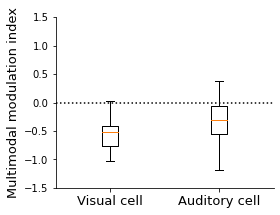

Mann-Whitney U test between Visual cells and Auditory cells
------------------------------------------------------
     U-val alternative     p-val       RBC      CLES
MWU  162.0   two-sided  0.011913  0.428571  0.285714


One-sample mwu with hypothesized median 0
$$ Visual $$
WilcoxonResult(statistic=2.0, pvalue=2.86102294921875e-06)
$$ Audidtory $$
WilcoxonResult(statistic=42.0, pvalue=0.00041293675625687486)


In [19]:
fig,ax = plt.subplots(figsize=(4,3))

x = ['Visual cell','Auditory cell']
y = [df.loc[df['Category']=='visual','pref_MV_mod'],
     df.loc[df['Category']=='auditory','pref_MA_mod']]
ax.boxplot(y);
ax.set_xticklabels(x, fontsize=13);
ax.set_yticks(np.arange(-1.5,2,0.5));
ax.set_ylabel('Multimodal modulation index', fontsize=13)
ax.axhline(y=0,linestyle=':', color='k')

plt.tight_layout()
#plt.savefig(fig_path / 'visual_auditory_multimodal_modulation_boxplot.png', dpi=300,facecolor='white')
#plt.savefig(fig_path / 'svg' / 'visual_auditory_multimodal_modulation_boxplot.svg')
plt.show()

print('Mann-Whitney U test between Visual cells and Auditory cells')
print('------------------------------------------------------')
print(pg.mwu(y[0],y[1]))
print('')
print('======================================================')
print('')
print('One-sample mwu with hypothesized median 0')
print('$$ Visual $$')
print(stats.wilcoxon(y[0], zero_method='wilcox'))
print('$$ Audidtory $$')
print(stats.wilcoxon(y[1], zero_method='wilcox'))

one-sample mwu results should be compared with SPSS results
***

#### Within crossmodal cells

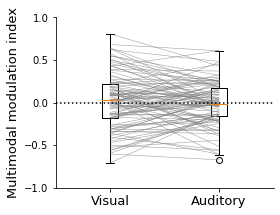

Wilcoxon Signed Rank test between Visual and Auditory
------------------------------------------------------
           W-val alternative     p-val       RBC      CLES
Wilcoxon  2274.0   two-sided  0.307881  0.117065  0.532105


One-sample mwu with hypothesized median 0
$$ Visual $$
WilcoxonResult(statistic=2369.0, pvalue=0.48421026478630347)
$$ Audidtory $$
WilcoxonResult(statistic=2481.0, pvalue=0.7488685201752303)


In [20]:
fig,ax = plt.subplots(figsize=(4,3))

x = ['Visual','Auditory']
y = df.loc[df['Category']=='unbiased',['pref_MV_mod','pref_MA_mod']].to_numpy()
ax.boxplot(y);
for i in range(len(y)):
    ax.plot([1,2],y[i,:], color='tab:gray', alpha=0.8, linewidth=0.5)

ax.set_xticklabels(x, fontsize=13);
ax.set_yticks(np.arange(-1,1.5,0.5));
ax.set_ylabel('Multimodal modulation index', fontsize=13)
ax.axhline(y=0,linestyle=':', color='k')

plt.tight_layout()
#plt.savefig(fig_path / 'unbiased_multimodal_modulation_boxplot.png', dpi=300,facecolor='white')
plt.savefig(fig_path / 'svg' / 'unbiased_multimodal_modulation_boxplot.svg')
plt.show()

print('Wilcoxon Signed Rank test between Visual and Auditory')
print('------------------------------------------------------')
print(pg.wilcoxon(y[:,0],y[:,1]))
print('')
print('======================================================')
print('')
print('One-sample mwu with hypothesized median 0')
print('$$ Visual $$')
print(stats.wilcoxon(y[:,0], zero_method='wilcox'))
print('$$ Audidtory $$')
print(stats.wilcoxon(y[:,1], zero_method='wilcox'))

one-sample mwu results should be compared with SPSS results
***

### Rate modulation indices (VA-V and VA-A)

#### Visual and auditory cells

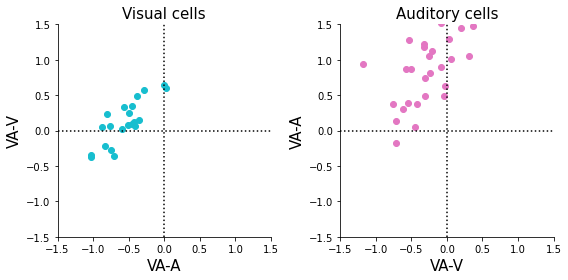

In [13]:
fig,ax = plt.subplots(1,2, figsize=(8,4))

ax[0].scatter(df.loc[df['Category']=='visual','pref_MV_mod'], 
              df.loc[df['Category']=='visual','pref_MA_mod'], color='tab:cyan')
ax[0].axhline(y=0, color='black', linestyle=':')
ax[0].axvline(x=0, color='black', linestyle=':')
ax[0].set_xlim([-1.5, 1.5]);
ax[0].set_xticks(np.arange(-1.5, 1.6, 0.5));
ax[0].set_ylim([-1.5, 1.5]);
ax[0].set_yticks(np.arange(-1.5, 1.6, 0.5));
ax[0].set_xlabel('VA-A', fontsize=15)
ax[0].set_ylabel('VA-V', fontsize=15)
ax[0].set_title('Visual cells', fontsize=15)

#x1 = df.loc[df['Category']=='visual','pref_MV_mod'].mean()
#sem1 = df.loc[df['Category']=='visual','pref_MV_mod'].sem()
#x2 = df.loc[df['Category']=='visual','pref_MA_mod'].mean()
#sem2 = df.loc[df['Category']=='visual','pref_MA_mod'].sem()
#ax[0].errorbar(x1, x2, xerr=sem1, yerr=sem2, fmt='s')

ax[1].scatter(df.loc[df['Category']=='auditory','pref_MA_mod'],
              df.loc[df['Category']=='auditory','pref_MV_mod'], color='tab:pink')
ax[1].axhline(y=0, color='black', linestyle=':')
ax[1].axvline(x=0, color='black', linestyle=':')
ax[1].set_xlim([-1.5, 1.5]);
ax[1].set_xticks(np.arange(-1.5, 1.6, 0.5));
ax[1].set_ylim([-1.5, 1.5]);
ax[1].set_yticks(np.arange(-1.5, 1.6, 0.5));
ax[1].set_xlabel('VA-V', fontsize=15)
ax[1].set_ylabel('VA-A', fontsize=15)
ax[1].set_title('Auditory cells', fontsize=15)

#x1 = df.loc[df['Category']=='auditory','pref_MA_mod'].mean()
#sem1 = df.loc[df['Category']=='auditory','pref_MA_mod'].sem()
#x2 = df.loc[df['Category']=='auditory','pref_MV_mod'].mean()
#sem2 = df.loc[df['Category']=='auditory','pref_MV_mod'].sem()
#ax[1].errorbar(x1, x2, xerr=sem1, yerr=sem2, fmt='s')

plt.tight_layout()

#plt.savefig(fig_path / 'svg' / 'VA-V_VA_A_index_scatter.svg')

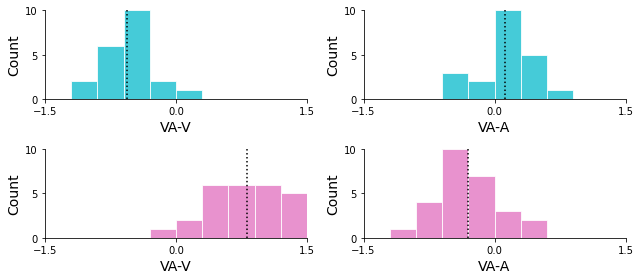

In [51]:
fig,ax = plt.subplots(2,2,figsize=(9,4))

x = ['pref_MV_mod', 'pref_MA_mod']
xlabel = ['VA-V', 'VA-A']

for i in range(2):
    ax[0,i].hist(df.loc[df['Category']=='visual',x[i]], color='tab:cyan', bins=np.arange(-1.5,1.6,0.3), alpha=0.8, ec='white');
    ax[0,i].axvline(x=df.loc[df['Category']=='visual',x[i]].mean(),color='black',linestyle=':')
    ax[0,i].set_xlabel(xlabel[i], fontsize=14);
    ax[0,i].set_xticks(np.arange(-1.5,1.6,1.5));
    ax[0,i].set_xlim([-1.5,1.5])
    ax[0,i].set_ylabel('Count', fontsize=14);
    #ax[0,i].set_yticks(np.arange(0,45,10));
    ax[0,i].set_ylim([0,10])
    ax[0,i].set_yticks([0,5,10])
    
    ax[1,i].hist(df.loc[df['Category']=='auditory',x[i]], color='tab:pink', bins=np.arange(-1.5,1.6,0.3), alpha=0.8, ec='white');
    ax[1,i].axvline(x=df.loc[df['Category']=='auditory',x[i]].mean(),color='black',linestyle=':')
    ax[1,i].set_xlabel(xlabel[i], fontsize=14);
    ax[1,i].set_xticks(np.arange(-1.5,1.6,1.5));
    ax[1,i].set_xlim([-1.5,1.5])
    ax[1,i].set_ylabel('Count', fontsize=14);
    ax[1,i].set_ylim([0,10])
    ax[1,i].set_yticks([0,5,10])
    
plt.tight_layout()
#plt.savefig(fig_path / 'image_sound_hist.png', dpi=300,facecolor='white')
plt.savefig(fig_path / 'svg' / 'VA-V_VA-A_hist.svg')

In [19]:
print('Visual cells')
print('VA-V')
print(pg.ttest(df.loc[df['Category']=='visual','pref_MV_mod'], y = 0))
print('VA-A')
print(pg.ttest(df.loc[df['Category']=='visual','pref_MA_mod'], y = 0))

print('===================================================================')
print('Auditory cells')
print('VA-A')
print(pg.ttest(df.loc[df['Category']=='auditory','pref_MA_mod'], y = 0))
print('VA-V')
print(pg.ttest(df.loc[df['Category']=='auditory','pref_MV_mod'], y = 0))

Visual cells
VA-V
               T  dof alternative         p-val           CI95%   cohen-d  \
T-test -8.904344   20   two-sided  2.144607e-08  [-0.69, -0.43]  1.943087   

             BF10  power  
T-test  6.219e+05    1.0  
VA-A
               T  dof alternative     p-val          CI95%   cohen-d   BF10  \
T-test  1.776517   20   two-sided  0.090863  [-0.02, 0.26]  0.387668  0.863   

           power  
T-test  0.394215  
Auditory cells
VA-A
               T  dof alternative     p-val           CI95%   cohen-d  \
T-test -4.476013   26   two-sided  0.000134  [-0.45, -0.17]  0.861409   

           BF10     power  
T-test  203.629  0.990496  
VA-V
               T  dof alternative         p-val         CI95%   cohen-d  \
T-test  9.181568   26   two-sided  1.216453e-09  [0.63, 0.99]  1.766993   

             BF10  power  
T-test  9.359e+06    1.0  


#### Crossmodal cells

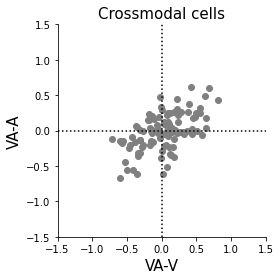

In [18]:
fig,ax = plt.subplots(figsize=(4,4))

ax.scatter(df.loc[df['Category']=='unbiased','pref_MV_mod'], 
              df.loc[df['Category']=='unbiased','pref_MA_mod'], color='gray')
ax.axhline(y=0, color='black', linestyle=':')
ax.axvline(x=0, color='black', linestyle=':')
ax.set_xlim([-1.5, 1.5]);
ax.set_xticks(np.arange(-1.5, 1.6, 0.5));
ax.set_ylim([-1.5, 1.5]);
ax.set_yticks(np.arange(-1.5, 1.6, 0.5));
ax.set_xlabel('VA-V', fontsize=15)
ax.set_ylabel('VA-A', fontsize=15)
ax.set_title('Crossmodal cells', fontsize=15)

plt.tight_layout()

plt.savefig(fig_path / 'svg' / 'VA-V_VA-A_crossmodal_scatter.svg')

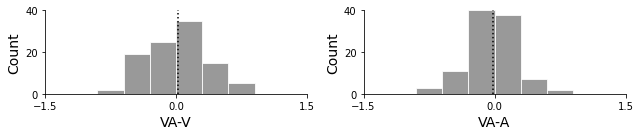

Crossmodal cells
VA-V
               T  dof alternative     p-val          CI95%   cohen-d   BF10  \
T-test  0.695386  100   two-sided  0.488427  [-0.04, 0.09]  0.069193  0.139   

           power  
T-test  0.105862  
VA-A
               T  dof alternative     p-val          CI95%   cohen-d   BF10  \
T-test -0.494462  100   two-sided  0.622065  [-0.06, 0.04]  0.049201  0.124   

           power  
T-test  0.077898  


In [17]:
fig,ax = plt.subplots(1,2,figsize=(9,2))

x = ['pref_MV_mod', 'pref_MA_mod']
xlabel = ['VA-V', 'VA-A']

for i in range(2):
    ax[i].hist(df.loc[df['Category']=='unbiased',x[i]], color='gray', bins=np.arange(-1.5,1.6,0.3), alpha=0.8, ec='white');
    ax[i].axvline(x=df.loc[df['Category']=='unbiased',x[i]].mean(),color='black',linestyle=':')
    ax[i].set_xlabel(xlabel[i], fontsize=14);
    ax[i].set_xticks(np.arange(-1.5,1.6,1.5));
    ax[i].set_xlim([-1.5,1.5])
    ax[i].set_ylabel('Count', fontsize=14);
    #ax[0,i].set_yticks(np.arange(0,45,10));
    ax[i].set_ylim([0,40])
    ax[i].set_yticks(np.arange(0,41,20))

plt.tight_layout()
#plt.savefig(fig_path / 'image_sound_hist.png', dpi=300,facecolor='white')
plt.savefig(fig_path / 'svg' / 'VA-V_VA-A_crossmodal_hist.svg')
plt.show()

print('Crossmodal cells')
print('VA-V')
print(pg.ttest(df.loc[df['Category']=='unbiased','pref_MV_mod'], y = 0))
print('VA-A')
print(pg.ttest(df.loc[df['Category']=='unbiased','pref_MA_mod'], y = 0))

### Multisensory modulation index and performance (correctness)

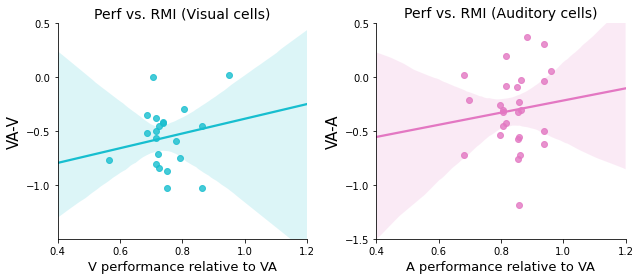

Linear regression result (visual cell)
                            OLS Regression Results                            
Dep. Variable:            pref_MV_mod   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                 -0.016
Method:                 Least Squares   F-statistic:                    0.6871
Date:                Thu, 02 Nov 2023   Prob (F-statistic):              0.417
Time:                        16:20:48   Log-Likelihood:                -2.6995
No. Observations:                  21   AIC:                             9.399
Df Residuals:                      19   BIC:                             11.49
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        

In [9]:
fig,ax = plt.subplots(1,2, figsize=(9,4))

# Visual cells

x1 = df.loc[df['Category']=='visual','V_corr']/df.loc[df['Category']=='visual','M_corr']
y1 = df.loc[df['Category']=='visual','pref_MV_mod']

ax[0].set_xlim([0.4,1.2])
ax[0].set_ylim([-1.5,0.5])

ax[0].set_xticks(np.arange(0.4,1.3,0.2));
ax[0].set_yticks(np.arange(-1,0.6,0.5));

ax[0].set_title('Perf vs. RMI (Visual cells)', fontsize=14)
sns.regplot(x=x1, y=y1, ax=ax[0], truncate=False, color='tab:cyan')

ax[0].set_xlabel('V performance relative to VA', fontsize=13)
ax[0].set_ylabel('VA-V', fontsize=15)

#####################################################################################

# Auditory cells

x2 = df.loc[df['Category']=='auditory','A_corr']/df.loc[df['Category']=='auditory','M_corr']
y2 = df.loc[df['Category']=='auditory','pref_MA_mod']

ax[1].set_xlim([0.4,1.2])
ax[1].set_ylim([-1.5,0.5])

ax[1].set_xticks(np.arange(0.4,1.3,0.2));
ax[1].set_yticks(np.arange(-1.5,0.6,0.5));

ax[1].set_title('Perf vs. RMI (Auditory cells)', fontsize=14)
sns.regplot(x=x2, y=y2, ax=ax[1], truncate=False, color='tab:pink')

ax[1].set_xlabel('A performance relative to VA', fontsize=13)
ax[1].set_ylabel('VA-A', fontsize=15)

plt.tight_layout()
#plt.savefig(fig_path / 'svg' / 'RMI_performance.svg')
plt.show()

#######################################################################################

# linear regression result
lr1 = sm.OLS(y1, sm.add_constant(x1)).fit()
print('Linear regression result (visual cell)')
print(lr1.summary())

print('')
print('==============================================================================')
print('')

lr2 = sm.OLS(y2, sm.add_constant(x2)).fit()
print('Linear regression result (auditory cell)')
print(lr2.summary())

In [10]:
print(stats.pearsonr(x1, y1))
print(stats.pearsonr(x2, y2))

(0.1868215789243532, 0.41743610644705154)
(0.11572544294339385, 0.5654198340664887)


### Multisensory modulation index and recording session
This analysis is to verify that multisensory suppression was not induced by novelty effect.
If multisensory suppression appeared only in the early recording session, firing rate differences between the unimodal and multimodal conditions could be explained by novelty effect, rather than by multisensory modulation.

In [12]:
df['session'] = df['session'].apply(int)

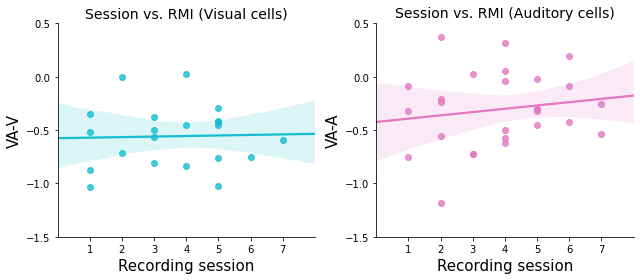

Linear regression result (visual cell)
                            OLS Regression Results                            
Dep. Variable:            pref_MV_mod   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.052
Method:                 Least Squares   F-statistic:                   0.01904
Date:                Thu, 02 Nov 2023   Prob (F-statistic):              0.892
Time:                        16:38:27   Log-Likelihood:                -3.0620
No. Observations:                  21   AIC:                             10.12
Df Residuals:                      19   BIC:                             12.21
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        

In [13]:
fig,ax = plt.subplots(1,2, figsize=(9,4))

# Visual cells

x1 = df.loc[df['Category']=='visual','session']
y1 = df.loc[df['Category']=='visual','pref_MV_mod']

ax[0].set_xlim([0,8])
ax[0].set_ylim([-1,0.5])

ax[0].set_xticks(np.arange(1,8,1));
ax[0].set_yticks(np.arange(-1.5,0.6,0.5));

ax[0].set_title('Session vs. RMI (Visual cells)', fontsize=14)
sns.regplot(x=x1, y=y1, ax=ax[0], truncate=False, robust=False, color='tab:cyan')

ax[0].set_xlabel('Recording session', fontsize=15)
ax[0].set_ylabel('VA-V', fontsize=15)

#####################################################################################

# Auditory cells

x2 = df.loc[df['Category']=='auditory','session']
y2 = df.loc[df['Category']=='auditory','pref_MA_mod']

ax[1].set_xlim([0,8])
ax[1].set_ylim([-1,0.5])

ax[1].set_xticks(np.arange(1,8,1));
ax[1].set_yticks(np.arange(-1.5,0.6,0.5));

ax[1].set_title('Session vs. RMI (Auditory cells)', fontsize=14)
sns.regplot(x=x2, y=y2, ax=ax[1], truncate=False, robust=False, color='tab:pink')

ax[1].set_xlabel('Recording session', fontsize=15)
ax[1].set_ylabel('VA-A', fontsize=15)

plt.tight_layout()
#plt.savefig(fig_path / 'svg' / 'RMI_recording_sessions.svg')
plt.show()

#######################################################################################

# linear regression result

lr1 = sm.OLS(y1, sm.add_constant(x1)).fit()
print('Linear regression result (visual cell)')
print(lr1.summary())

print('')
print('==============================================================================')
print('')

lr2 = sm.OLS(y2, sm.add_constant(x2)).fit()
print('Linear regression result (auditory cell)')
print(lr2.summary())

In [14]:
print(stats.pearsonr(x1, y1))
print(stats.pearsonr(x2, y2))

(0.0316409231162979, 0.891701273372929)
(0.15638358108149225, 0.436007435560533)


### Linear relationship between M-V and M-A within crossmodal cells

                            OLS Regression Results                            
Dep. Variable:            pref_MA_mod   R-squared:                       0.306
Model:                            OLS   Adj. R-squared:                  0.299
Method:                 Least Squares   F-statistic:                     43.73
Date:                Mon, 24 Jul 2023   Prob (F-statistic):           1.93e-09
Time:                        22:31:00   Log-Likelihood:                 10.533
No. Observations:                 101   AIC:                            -17.07
Df Residuals:                      99   BIC:                            -11.84
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0230      0.022     -1.048      

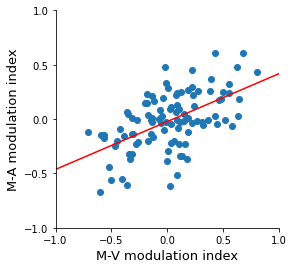

In [45]:
x = df.loc[df['Category']=='unbiased','pref_MV_mod']
y = df.loc[df['Category']=='unbiased','pref_MA_mod']

lr = sm.OLS(y, sm.add_constant(x)).fit()
print(lr.summary())

fig,ax = plt.subplots(figsize=(4,4))

ax.scatter(x,y)
x1 = np.arange(-1,1.1,0.1)
ax.plot(x1, lr.params[1]*x1+lr.params[0], color='red')

ax.set_xticks(np.arange(-1,1.1,0.5));
ax.set_xlim([-1,1])
ax.set_xlabel('M-V modulation index', fontsize=13)
ax.set_yticks(np.arange(-1,1.1,0.5));
ax.set_ylim([-1,1])
ax.set_ylabel('M-A modulation index', fontsize=13)

#plt.savefig(fig_path / 'svg' / 'MV_MA_index_scatter.svg')

<AxesSubplot:xlabel='pref_MV_mod', ylabel='pref_MA_mod'>

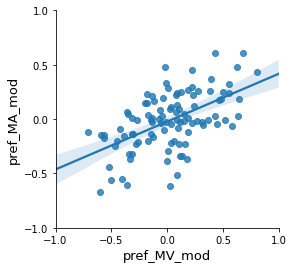

In [61]:
# added confidence interval for regression line using seaborn

x = df.loc[df['Category']=='unbiased','pref_MV_mod']
y = df.loc[df['Category']=='unbiased','pref_MA_mod']

fig,ax = plt.subplots(figsize=(4,4))

ax.set_xlim([-1,1])
ax.set_ylim([-1,1])

ax.set_xticks(np.arange(-1,1.1,0.5));
ax.set_xlabel('M-V modulation index', fontsize=13)
ax.set_yticks(np.arange(-1,1.1,0.5));
ax.set_ylabel('M-A modulation index', fontsize=13)

sns.regplot(x='pref_MV_mod', y='pref_MA_mod', data=df[df.Category=='unbiased'], ax=ax, truncate=False)

#plt.savefig(fig_path / 'svg' / 'MV_MA_index_scatter.svg')

### Multimodal modulation index and peak selectivity time
(not used)

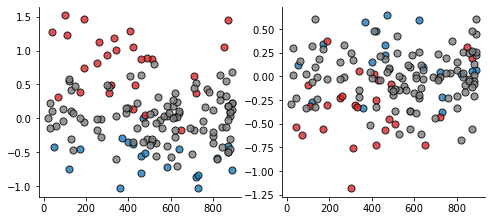

In [12]:
fig,ax = plt.subplots(1,2,figsize=(8,3.5))

cat = ['visual','auditory','unbiased']
for i in range(len(cat)):
    x = df.loc[df['Category']==cat[i],'peak_selectivity_time']
    y = df.loc[df['Category']==cat[i],'pref_MV_mod']
    y2 = df.loc[df['Category']==cat[i],'pref_MA_mod']
    ax[0].scatter(x, y, facecolor=color[i], edgecolors='k', alpha=0.8, s=50)
    ax[1].scatter(x, y2, facecolor=color[i], edgecolors='k', alpha=0.8, s=50)

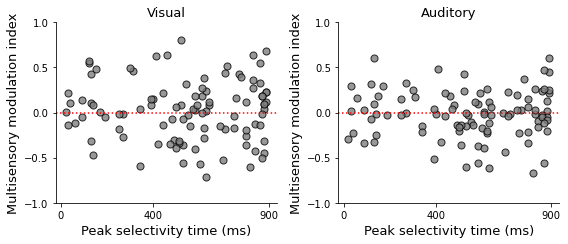

In [42]:
# Unbiased cell only

fig,ax = plt.subplots(1,2,figsize=(8,3.5))

x = df.loc[df['Category']=='unbiased','peak_selectivity_time']
y = df.loc[df['Category']=='unbiased','pref_MV_mod']
y2 = df.loc[df['Category']=='unbiased','pref_MA_mod']

ax[0].scatter(x, y, facecolor=color[2], edgecolors='k', alpha=0.8, s=50)
ax[1].scatter(x, y2, facecolor=color[2], edgecolors='k', alpha=0.8, s=50)

for i in range(2):
    ax[i].set_yticks(np.arange(-1,1.1,0.5))
    ax[i].set_xticks([0,400,900])
    ax[i].set_ylabel('Multisensory modulation index', fontsize=13)
    ax[i].set_xlabel('Peak selectivity time (ms)', fontsize=13)    
    ax[i].axhline(y=0,linestyle=':', color='red')
ax[0].set_title('Visual', fontsize=13)
ax[1].set_title('Auditory', fontsize=13)

plt.tight_layout()    
plt.savefig(fig_path / 'svg' / 'unbiased_multimodal_modulation_scatter.svg')

### Multimodal modulation index and selectivity index
(not used)

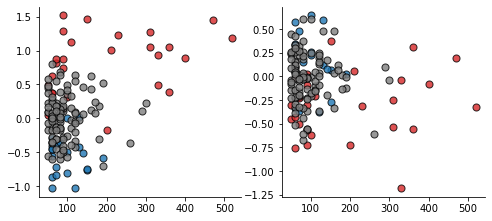

In [13]:
fig,ax = plt.subplots(1,2,figsize=(8,3.5))

cat = ['visual','auditory','unbiased']
for i in range(3):
    x = df.loc[df['Category']==cat[i],'selectivity_duration']
    y = df.loc[df['Category']==cat[i],'pref_MV_mod']
    y2 = df.loc[df['Category']==cat[i],'pref_MA_mod']
    ax[0].scatter(x, y, facecolor=color[i], edgecolors='k', alpha=0.8, s=50)
    ax[1].scatter(x, y2, facecolor=color[i], edgecolors='k', alpha=0.8, s=50)

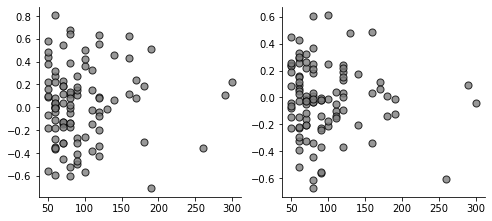

In [15]:
fig,ax = plt.subplots(1,2,figsize=(8,3.5))

x = df.loc[df['Category']=='unbiased','selectivity_duration']
y = df.loc[df['Category']=='unbiased','pref_MV_mod']
y2 = df.loc[df['Category']=='unbiased','pref_MA_mod']

ax[0].scatter(x, y, facecolor=color[2], edgecolors='k', alpha=0.8, s=50)
ax[1].scatter(x, y2, facecolor=color[2], edgecolors='k', alpha=0.8, s=50)